Add noise
Nguyen Viet Hoang 
Các noise model tác động lên chất lượng ảnh


In [3]:
from importlib.resources import path
from pathlib import Path 
import cv2
import numpy as np
import abc
from numpy.random import Generator
import matplotlib.pyplot as plt

class Noise(metaclass = abc.ABCMeta):
    def __init__(self, filepath: Path):
        self.filepath = filepath
        
    def get_matrix_image(self):
        return cv2.imread(str(self.filepath), cv2.IMREAD_GRAYSCALE)
    
    @abc.abstractmethod
    def noise(self)->np.array:
        pass
    
    def add_noise(self) ->np.array:
        noise_gen = self.noise()
        origin_image = self.get_matrix_image()
        noisy_image = cv2.add(origin_image,noise_gen)
        cv2.normalize(noisy_image, noisy_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)
        return noisy_image
       
class GaussianNoise(Noise):
    def __init__(self, filepath, mean = 0, var = 0.1):
        super().__init__(filepath=filepath)
        self.mean = mean
        self.var = var
    
    def noise(self)->np.array:
        image = self.get_matrix_image()
        row, col = image.shape
        sigma = self.var**0.5
        gauss = np.random.normal(self.mean,sigma,image.size)
        gauss = gauss.reshape(row, col).astype('uint8')
        return gauss
  
class RayleighNoise(Noise):
    def __init__(self, filepath, scale):
        super().__init__(filepath=filepath)
        self.scale = scale
        
    def noise(self)->np.array:
        image = self.get_matrix_image()
        row, col, ch = image.shape
        rayleigh = np.random.rayleigh(self.scale, (row, col, ch))
        return rayleigh
    
class ExponentialNoise(Noise):
    def __init__(self, filepath, scale):
        super().__init__(filepath = filepath)
        self.scale = scale
        
    def noise(self)->np.array:
        image = self.get_matrix_image()
        row, col, ch = image.shape        
        exponent = Generator.exponential(self.scale, (row, col, ch))
        return exponent
    
class SaltAndPeperNoise(Noise):
    def __init__(self,
                 filepath: Path,
                 s_vs_p = 0.5,
                 amount = 0.004):
        super().__init__(filepath)
        self.s_vs_p = s_vs_p
        self.amount = amount
    
    def noise(self)->np.array:
        image = self.get_matrix_image()
        # row,col,ch = image.shape

        out = np.copy(image)
        
        # Salt mode
        num_salt = np.ceil(self.amount * image.size * self.s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
                for i in image.shape]
        out[tuple(coords)] = 1
        
        # Pepper mode
        num_pepper = np.ceil(self.amount* image.size * (1. - self.s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
                for i in image.shape]
        
        out[tuple(coords)] = 0
        return np.asarray(out)
     
class UniformNoise(Noise):
    def __init__(self,
                 filepath:Path,
                 a = 0.0, 
                 b = 1.0):
        super().__init__(filepath=filepath)
        self.a = a
        self.b = b
        
    def noise(self)->np.array:
        image = self.get_matrix_image()
        row, col, ch = image.shape
        uniform_gen = Generator.uniform(self.a, self.b, (row, col, ch))
        return np.asarray(uniform_gen)
    


        

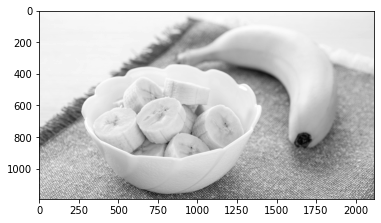

In [9]:
import cv2
from config import Flag
import matplotlib.pyplot as plt


prefix = Flag.image_origin
file_name = prefix / 'banana.jpg'
image = cv2.imread(str(file_name), cv2.IMREAD_GRAYSCALE)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image, cmap='gray')



In [10]:
def metric(gt, ri):
    SE = (gt - ri)**2
    MSE = SE.mean()
    PSNR = 10*np.log10(255*255/MSE)
    return {"MSE": MSE,"PSNR":PSNR}
               

{'MSE': 34.48921364118202, 'PSNR': 32.753970683616004}


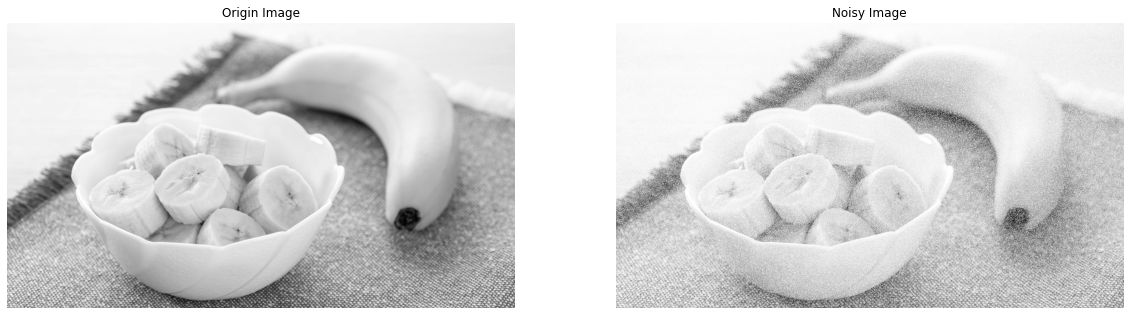

In [36]:
# from add_noise import GaussianNoise
gauss_noise = GaussianNoise(str(file_name), mean = 0, var = 3.5)
image_gauss_noise = gauss_noise.add_noise()
# print(image_gauss_noise.shape)
eval_img = metric(image, image_gauss_noise)
print(eval_img)

plt.figure(figsize=(20, 12))
plt.subplot(121)
plt.title("Origin Image")
plt.axis('off')
plt.imshow(image, cmap='gray')
plt.subplot(122)
plt.title("Noisy Image")
plt.axis('off')
plt.imshow(image_gauss_noise, cmap='gray')

{'MSE': 12.101608276367188, 'PSNR': 37.30237269961597}


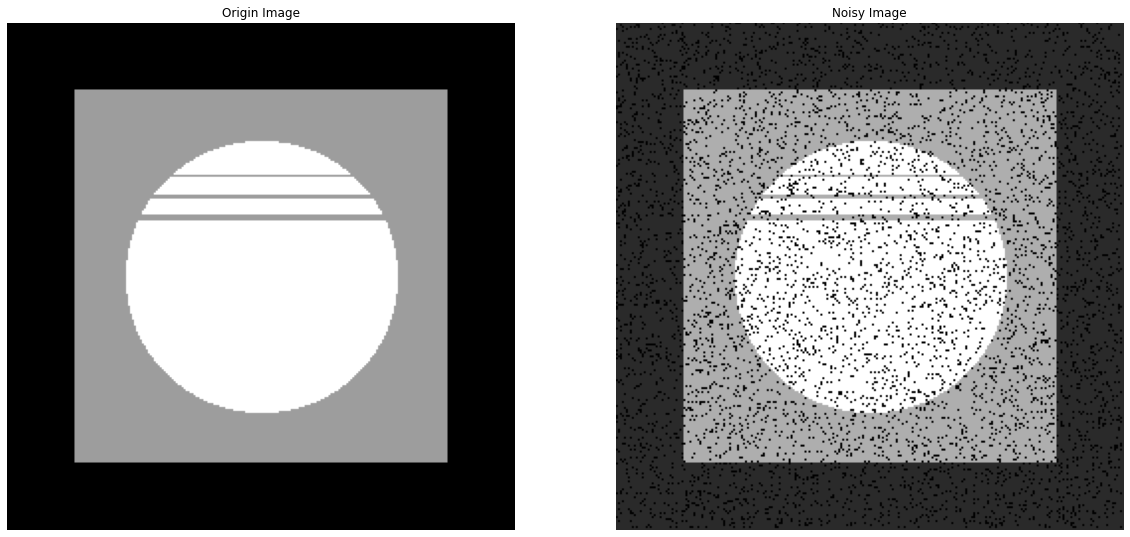

In [45]:
# from add_noise import SaltAndPeperNoise
file_name = prefix / 'pattern2.png'
image = cv2.imread(str(file_name), cv2.IMREAD_GRAYSCALE)

saltAndPeperNoise = SaltAndPeperNoise(str(file_name), s_vs_p=1, amount=0.1)
image_snp_noise = saltAndPeperNoise.noise()

metric_snp = metric(image, image_snp_noise)

print(metric_snp)

plt.figure(figsize=(20, 12))
plt.subplot(121)
plt.title("Origin Image")
plt.axis('off')
plt.imshow(image, cmap='gray')
plt.subplot(122)
plt.title("Noisy Image")
plt.axis('off')
plt.imshow(image_snp_noise, cmap='gray')

In [21]:
from add_noise import UniformNoise
uni_noise = UniformNoise(filepath=file_name)
noise_image = image+uni_noise.noise()
plt.imshow(noise_image)



ValueError: not enough values to unpack (expected 3, got 2)